# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Импорт необходиммых библиотек

In [2]:
import sys
import spacy
import pandas as pd 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

## Подготовка

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')
display(data.sample(5))

#Избавимся от столбца Unnamed т.к. бесполезен

data = data.drop(columns = ['Unnamed: 0'], axis = 1)
display(data.sample(5))

,Unnamed: 0,text,toxic
33636,33676,"""\n\nMilton, MA\nHey Markles, I was hoping you...",0
136034,136172,"""\n\ncats\nYou should fill up Category:Hindus_...",0
65818,65885,After reading the pivorse one it is the best p...,0
136562,136700,The comments you have referred are about his ...,0
103070,103167,"""\n\nNo, Dolphin52, you have not provided any ...",0


,text,toxic
95595,His personal Web site has vanished \n\nAs of t...,0
103084,"""\n\nFebruary 22\n Please stop adding nonsense...",0
152402,Who and Why keeps deleting the I Stand Alone s...,0
9206,It's amazing a group of suspiciously coordinat...,0
75347,Please delete the Draft:Later Sui Empire. I Wa...,0


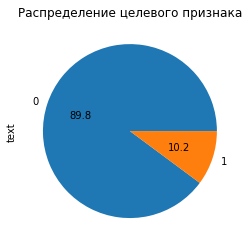

In [4]:
#Проверим количество текста токсик 

data.groupby('toxic')['text'].count().plot(kind = 'pie', autopct = '%.1f')
plt.title('Распределение целевого признака')
plt.show()

### Предобработка информации для классических алгоритмов МО (не нейронная сеть) 

<div style = "border:solid Green 2px; padding: 20px">
    Предобработка в данном разделе <b>должна</b> состоять из следующих пунктов:
    
- Разделим на X и y выборку 
- Преобразуем текст в формат юникод 
- Лемматизировать и очистить выборку
- Разделить на трейновую и тестовую выборки
- Выгрузим стопслова на английском 
- Обучить TfidfVectorizer на трейновой и тестовой выборке

In [5]:
# Осуществляем деление на трейн и тест выборку 

X = data['text']
y = data['toxic']

In [6]:
X.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

In [7]:
# Понизим регистр, очистим выгрузку от лишних символов, произведем лемматизацию 

X_clear = []

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

for i in tqdm(X):

    low_one = i.lower()
    clear_one = re.sub(r'[^a-z]', ' ', low_one)
    clear_one = ' '.join(clear_one.split())
    
    doc = nlp(clear_one)
    lemmas = " ".join([token.lemma_ for token in doc])

    X_clear.append(lemmas)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
X_clear = pd.Series(X_clear)
X_clear.head()

0    explanation why the edit make under my usernam...
1    d aww he match this background colour I m seem...
2    hey man I m really not try to edit war it s ju...
3    more I can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
dtype: object

In [9]:
X_train, X_test, y_train, y_test = train_test_split (X_clear, y, test_size = 0.25, random_state = 12341, stratify=y)

In [10]:
def check_train_test (X, y):
    if X.index.equals(y.index) and len(X) == len(y):
        print('Корректно')
    else:
        print('Некорректно, проверь')

check_train_test (X_train, y_train)
check_train_test (X_test, y_test)           

Корректно
Корректно


In [11]:
#Вычислим TF-IDF, засовываем в пайплайн

nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

#count_tf_idf = TfidfVectorizer(stop_words = stopwords)

#X_train_tf_idf = count_tf_idf.fit_transform(X_train)
#X_test_tf_idf = count_tf_idf.transform(X_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

### Обучение с использованием классических моделей МО

<div style = 'border: solid green 2px; padding: 20px'>
    
    Для обучения необходимо выполнить следующие пункты: 
    
    - обучить модель, с использованием кросс-валидации подобрать лучшую модель/параметры
    - Провести предсказания на тестовой выборке 
   

In [13]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words = stopwords)),
    ('model', LogisticRegression())
])

params = [
    {'model' : [LogisticRegression(max_iter=500)]},
    {'model' : [SVC(kernel = 'linear')]},
    {'model' : [CatBoostClassifier()]}
]

gs = GridSearchCV (estimator = pipeline,
                  param_grid = params, 
                  scoring = 'f1',
                  n_jobs = -1,
                  cv = 2)

gs.fit(X_train, y_train)
print(gs.best_estimator_)
print(gs.best_score_)

Learning rate set to 0.059072
0:	learn: 0.6306413	total: 1.78s	remaining: 29m 35s
1:	learn: 0.5796525	total: 2.95s	remaining: 24m 30s
2:	learn: 0.5324306	total: 4.2s	remaining: 23m 16s
3:	learn: 0.4928697	total: 5.42s	remaining: 22m 28s
4:	learn: 0.4598213	total: 6.66s	remaining: 22m 5s
5:	learn: 0.4313829	total: 7.92s	remaining: 21m 51s
6:	learn: 0.4052481	total: 9.23s	remaining: 21m 49s
7:	learn: 0.3818867	total: 10.5s	remaining: 21m 45s
8:	learn: 0.3624190	total: 11.8s	remaining: 21m 42s
9:	learn: 0.3463652	total: 13.1s	remaining: 21m 40s
10:	learn: 0.3323176	total: 14.4s	remaining: 21m 33s
11:	learn: 0.3203433	total: 15.7s	remaining: 21m 28s
12:	learn: 0.3088865	total: 17s	remaining: 21m 27s
13:	learn: 0.2987376	total: 18.2s	remaining: 21m 24s
14:	learn: 0.2901084	total: 19.5s	remaining: 21m 20s
15:	learn: 0.2822234	total: 20.8s	remaining: 21m 16s
16:	learn: 0.2751914	total: 22s	remaining: 21m 12s
17:	learn: 0.2689812	total: 23.3s	remaining: 21m 9s
18:	learn: 0.2632403	total: 24.6s

In [14]:
print(f'Лучшая модель: {gs.best_estimator_}')

Лучшая модель: Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model', SVC(kernel='linear'))])


In [15]:
print(f'Метрика на кросс валидации: {gs.best_score_}')

Метрика на кросс валидации: 0.7664052569249252


In [16]:
y_pred = gs.predict(X_test)

In [17]:
print(f'Метрика на тестовой выборке: {f1_score(y_test, y_pred)}')

Метрика на тестовой выборке: 0.7713757291222081


## Выводы

По результату проведенного анализа, можно сделать сделать следующие выводы: 
1. Были рассмотрены данные, удален лишний столбец, не несущий никакой информативной ценности
2. данные были очищенны, понижен регистр, проведена лемматизация
3. При преобразовании текстов в векторную форму при помощи TF-IDF, были использованы стоп слова загруженные ранее (английский язык) 
4. При подборе лучшей модели, было рассмотренно 3: LogisticRegression, SCV, Catboost. Лучшей оказалась SCV с линейным ядром. 
5. Метрика на кросс валидации выше критерия успешности (0.752 > 0.75)
6. Метрика на тестовой выборке выше критерия успешности (0.773 > 0.75)

Рекомендации: 
Предлагаю использовать для поиска токсичных комментариев модель SVC(kernel = 'linear')